In [1]:
from pathlib import Path
import sys
import json
import datetime

PROJ_DIR = Path.cwd().parent.parent
sys.path.append(str(PROJ_DIR))

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import animation
from IPython.display import HTML

import numpy as np
import pandas as pd

from src.defaults import ROOT_DIR
from src.checkpoint import CheckpointableData, Checkpointer
from src.config import BaseConfig, Require
from src.shared import get_env
from src.smbpo import SMBPO
from src.tester import Tester
from src.viz_tracking.opt_controller import OptController

ROOT_DIR = Path(ROOT_DIR)
assert ROOT_DIR.is_dir(), ROOT_DIR
LOGS_DIR = ROOT_DIR / 'logs' / 'tracking'

params = {
    'font.family': 'Arial',
    # 'font.serif': 'Times New Roman',
    # 'font.style': 'italic',
    # 'font.weight': 'normal', #or 'blod'
    'font.size': 15,  # or large,small
    'animation.ffmpeg_path': r'/usr/bin/ffmpeg'
}
rcParams.update(params)

/home/zouwenjun/anaconda3/envs/torch/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class Config(BaseConfig):
    env_name = "tracking"
    env_cfg = {
        "pre_horizon" : 10,
        "surr_veh_num" : 1,
    }
    seed = 1
    epochs = 600
    alg_cfg = SMBPO.Config()
    alg = 'DRPO'
    opt_args={
        "num_pred_step": 20,
        "gamma": 0.99,
        "mode": "shooting",
        "minimize_options": {
            "max_iter": 200,
            "tol": 1e-3,
            "acceptable_tol": 1e-2,
            "acceptable_iter": 50,
            # "print_level": 5,
        },
        "use_terminal_cost": False,
        "verbose": 1,
    },

/home/zouwenjun/Downloads/safe-control-gym/safe_control_gym/utils/configuration.py:72: UserWarning: No agent/task config given.
  warnings.warn("No agent/task config given.")
/home/zouwenjun/anaconda3/envs/torch/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Test log directory: /home/zouwenjun/codes/Safe_MBRL/logs/tracking/MPC/test-2023-02-17-16-53-55
env <SimuVeh3dofcontiSurrCstr2 instance>
surr 0: d_lon: 8, d_lat: 3.5, u: 4.5

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'
Summary statistics:
* Number of iterations: 7
* Cost function calls: 9
* Constraint calls: 20
* System simulations: 29
* Final cost: 0.17328380048274994 



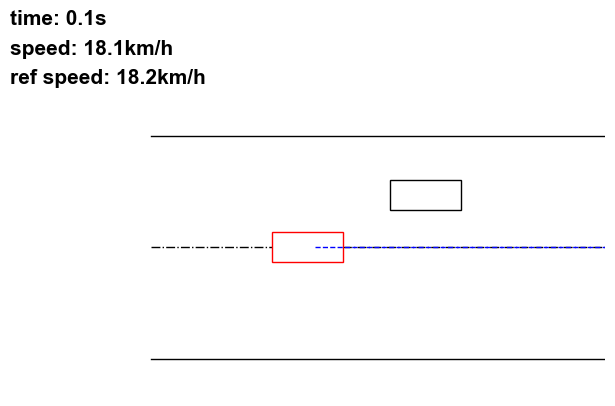

KeyboardInterrupt: 

In [3]:
from src.shared import get_env
from src.tester import mpc_sample_episodes_batched_with_infos
from src.env.tracking.pyth_veh3dofconti_surrcstr_model import Veh3dofcontiSurrCstrModel
env_name = "tracking_model"
log_dir = "MPC" # fill in this

# load cfg from the trained model
cfg = Config()

assert log_dir is not None, 'Must specify --run-dir'
run_dir = LOGS_DIR / log_dir
assert run_dir.is_dir(), f'Run directory does not exist: {run_dir}'

# with (run_dir / 'config.json').open('r') as f:
#     saved_cfg = json.load(f)
#     assert env_name == saved_cfg["env_name"]
#     cfg.update(saved_cfg)

cfg.alg_cfg.update(dict(mode='test'))
cfg.env_cfg.update(dict(render=True))

# Ensure all required arguments have been set
# cfg.verify()
for attr in ('env_name', 'seed'):
    assert hasattr(cfg, attr), f'Config must specify {attr}'

# creat MPC controller
model = Veh3dofcontiSurrCstrModel(**{**cfg.env_cfg, **dict(id=id)})
env = get_env(env_name, wrap_torch = False, rescale_action = False, **{**cfg.env_cfg, **dict(id=id)})
opt_args = cfg.opt_args[0]
MPC_controller = OptController(model, **opt_args,)

# load model and set env
time_now = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
test_log_dir = run_dir / 'test-{}'.format(time_now)
test_log_dir.mkdir(exist_ok=True, parents=True)

print(f'Test log directory: {test_log_dir}')

# run evaluation
print("env", env)
test_traj, info_traj = mpc_sample_episodes_batched_with_infos(env, MPC_controller, 1)

In [ ]:
# get necessary data trajectories
traj_len = len(test_traj[0].get("actions"))
time_steps = np.arange(traj_len) * 0.1

surrs_states = np.array(info_traj[0]["surr_state"], dtype=np.float32)
states = np.array(info_traj[0]["state"], dtype=np.float32)
actions = np.array(test_traj[0].get("actions").cpu().numpy(), dtype=np.float32)
constraints = np.array(info_traj[0]["constraint_value"], dtype=np.float32)
video = np.array(info_traj[0]["img"], dtype=np.float32) / 255.0

ego_pos = states[:, :2]
ref_pos = np.array(info_traj[0]["ref_points"], dtype=np.float32)[:, 0, :2]
surrs_poses = surrs_states[:, :, :2]

# scale actions with pi/6 and 3
actions[:, 0] *= np.pi / 6
actions[:, 1] *= 3

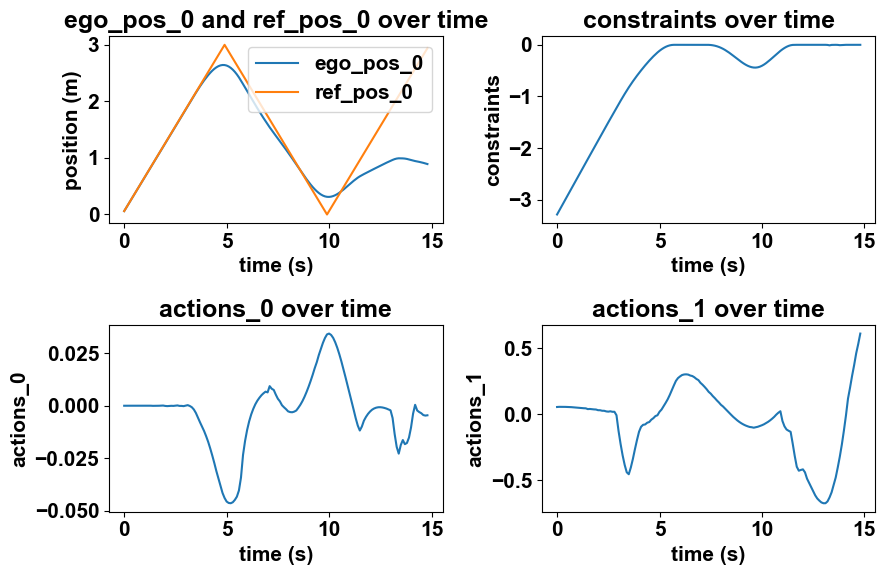

In [ ]:
# plot curves
# draw a 2 * 2 figure, where the top left is the ref_pos_1 (red) and ego_pos_1 (blue) evolution
# over time; top right the constraints; bottom left the actions_0; bottom right the actions_1
fig, axs = plt.subplots(2, 2, figsize=(9, 6))
axs[0, 0].plot(time_steps, ego_pos[:, 1], label="ego_pos_0")
axs[0, 0].plot(time_steps, ref_pos[:, 1], label="ref_pos_0")
axs[0, 0].set_title("ego_pos_0 and ref_pos_0 over time")
axs[0, 0].set_xlabel("time (s)")
axs[0, 0].set_ylabel("position (m)")
axs[0, 0].legend()

axs[0, 1].plot(time_steps, constraints)
axs[0, 1].set_title("constraints over time")
axs[0, 1].set_xlabel("time (s)")
axs[0, 1].set_ylabel("constraints")

axs[1, 0].plot(time_steps, actions[:, 0])
axs[1, 0].set_title("actions_0 over time")
axs[1, 0].set_xlabel("time (s)")
axs[1, 0].set_ylabel("actions_0")

axs[1, 1].plot(time_steps, actions[:, 1])
axs[1, 1].set_title("actions_1 over time")
axs[1, 1].set_xlabel("time (s)")
axs[1, 1].set_ylabel("actions_1")

fig.tight_layout()

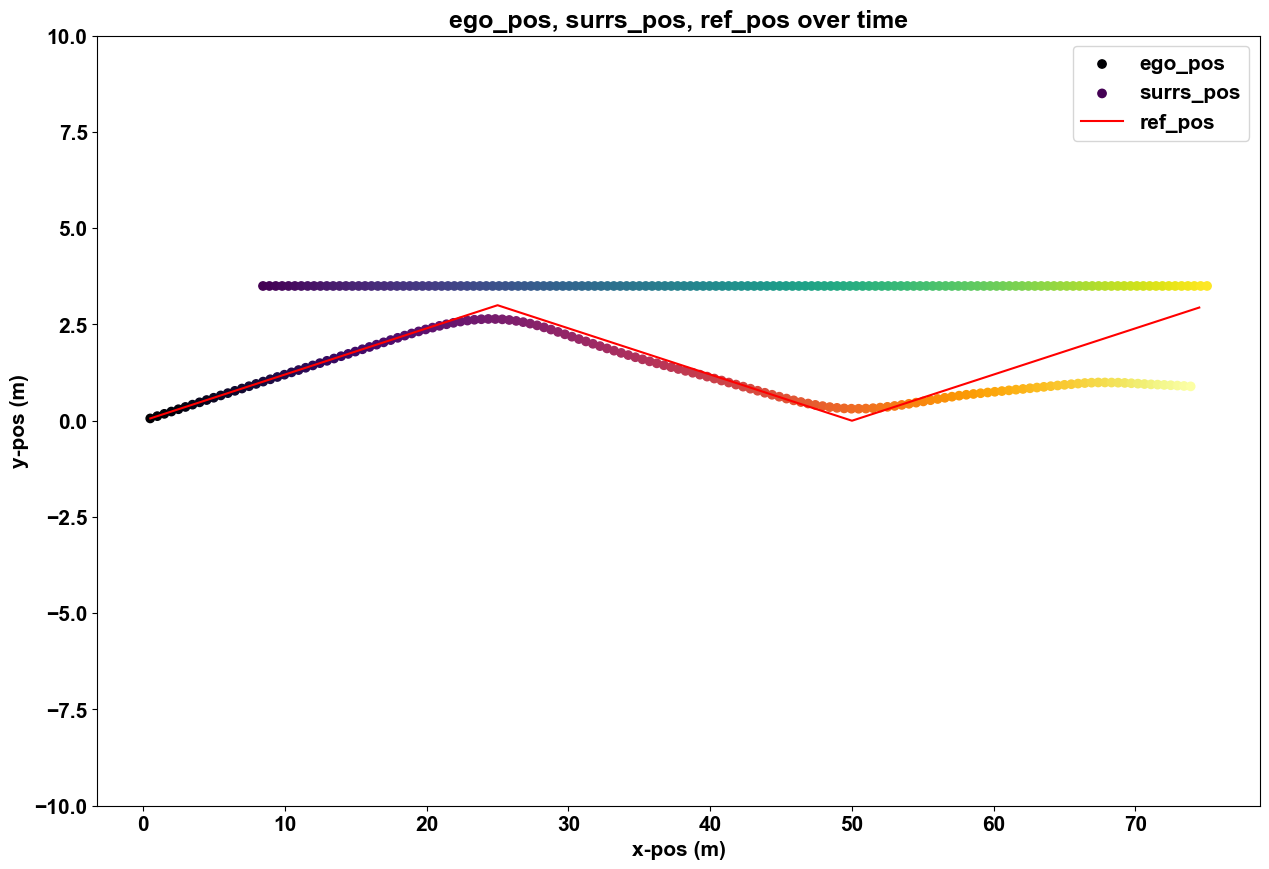

In [ ]:
# draw a figure about the ego_pos, surrs_poses, ref_pos evoluation
# x-pos_0, y-pos_1 with scatter
# the color should be darker as time goes by

fig, axs = plt.subplots(1, 1, figsize=(15, 10))
axs.scatter(ego_pos[:, 0], ego_pos[:, 1], c=time_steps, label="ego_pos", cmap="inferno")
axs.scatter(surrs_poses[:, :, 0], surrs_poses[:, :, 1], c=time_steps, label="surrs_pos", cmap="viridis")
axs.plot(ref_pos[:, 0], ref_pos[:, 1], label="ref_pos", c="red")
axs.set_title("ego_pos, surrs_pos, ref_pos over time")
axs.set_xlabel("x-pos (m)")
axs.set_ylabel("y-pos (m)")
axs.set_ylim(-10, 10)
axs.legend()

In [ ]:
# draw animations
fig = plt.figure()
im = plt.imshow(video[0,:,:,:])
plt.axis('off')

plt.close() # this is required to not display the generated image

def init():
    im.set_data(video[0,:,:,:])

def animate(i):
    im.set_data(video[i,:,:,:])
    return im

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=video.shape[0],
                               interval=50)
HTML(anim.to_html5_video())

NameError: name 'plt' is not defined